In [2]:
import sys
sys.path.append('../utils')

from preprocessing import Preprocessor

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image

import tensorflow as tf
tf.python.control_flow_ops = tf

## Initialise the data

In [13]:
train_cats, train_dogs, train_all, test_all = Preprocessor.get_dataset_paths()

labels = [[1., 0.] if 'dog' in name else [0., 1.] for name in train_all] # labels are one hot encoded

## Example of usage

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FA6FC36E320>


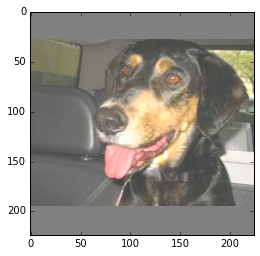

In [68]:
random_index = np.random.randint(0, len(train_all))
image_path = train_all[random_index]
image = Preprocessor.get_image(image_path)

processed_image = Preprocessor.get_processed_image(image)
print (processed_image)

plt.imshow(processed_image)
plt.show()

def get_processed_image_from_path(path):
    image = Preprocessor.get_image(path)
    processed_image = Preprocessor.get_processed_image(image)
    return np.array(processed_image)[:,:,0].ravel()

In [69]:
print (np.array(processed_image)[:,:,0].shape)

(224, 224)


## Model

In [70]:
dataset_size = 10
train = list(map(get_processed_image_from_path, train_all[:dataset_size]))
labels = labels[:dataset_size]

In [71]:
# Parameters
learning_rate = 0.001
training_iters = 200000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 224 * 224 
n_classes = 2 
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [72]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 224, 224, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [73]:

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

In [74]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step < training_iters:
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: train, y: labels, keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: train,
                                                              y: labels,
                                                              keep_prob: 1.})
            print ("Iter " + str(step) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print ("Optimization Finished!")

    # Calculate accuracy for 256 mnist test images
#     print ("Testing Accuracy:",
#         sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
#                                       y: mnist.test.labels[:256],
#                                       keep_prob: 1.}))

InvalidArgumentError: logits and labels must be same size: logits_size=[640,2] labels_size=[10,2]
	 [[Node: SoftmaxCrossEntropyWithLogits_5 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Add_9, _recv_Placeholder_30_0)]]
Caused by op 'SoftmaxCrossEntropyWithLogits_5', defined at:
  File "/home/weenkus/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/weenkus/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-73-10d77446c973>", line 25, in <module>
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 491, in softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1427, in _softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/weenkus/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()
